In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

In [2]:
def project_to_simplex(y):
    n = len(y)
    u = np.sort(y)[::-1]
    cumsum_u = np.cumsum(u)
    k = np.max(np.where(u > (cumsum_u - 1) / (np.arange(1, n + 1)))[0]) + 1
    theta = (cumsum_u[k - 1] - 1) / k
    return np.maximum(y - theta, 0)

# Hedge+BR updates
def hedge_br(x0, A_list, v_seq, T, rate, lr):
    x = x0.copy()
    x_list = [x.copy()]
    gaps = []

    for t in range(T):
        A_t = A_list[t % len(A_list)]
        v_ast = v_seq[t % len(v_seq)]
        y_idx = np.argmax(x @ A_t)
        y = np.zeros_like(x)
        y[y_idx] = 1

        x_list.append(x.copy())
        gaps.append(x @ A_t @ y - v_ast)

        grad = A_t @ y
        eta_t = lr / ((t+1)**rate)
        x *= np.exp(-eta_t * grad)
        x /= np.sum(x)

    return np.array(x_list), gaps

# PGD+BR updates
def pgd_br(x0, A_list, v_seq, T, rate, lr):
    x = x0.copy()
    x_list = [x.copy()]
    gaps = []

    for t in range(T):
        A_t = A_list[t % len(A_list)]
        v_ast = v_seq[t % len(v_seq)]
        y_idx = np.argmax(x @ A_t)
        y = np.zeros_like(x)
        y[y_idx] = 1

        x_list.append(x.copy())
        gaps.append(x @ A_t @ y - v_ast)

        grad = A_t @ y
        eta = lr / ((t+1) ** rate)
        x = project_to_simplex(x - eta * grad)
        
    return np.array(x_list), gaps

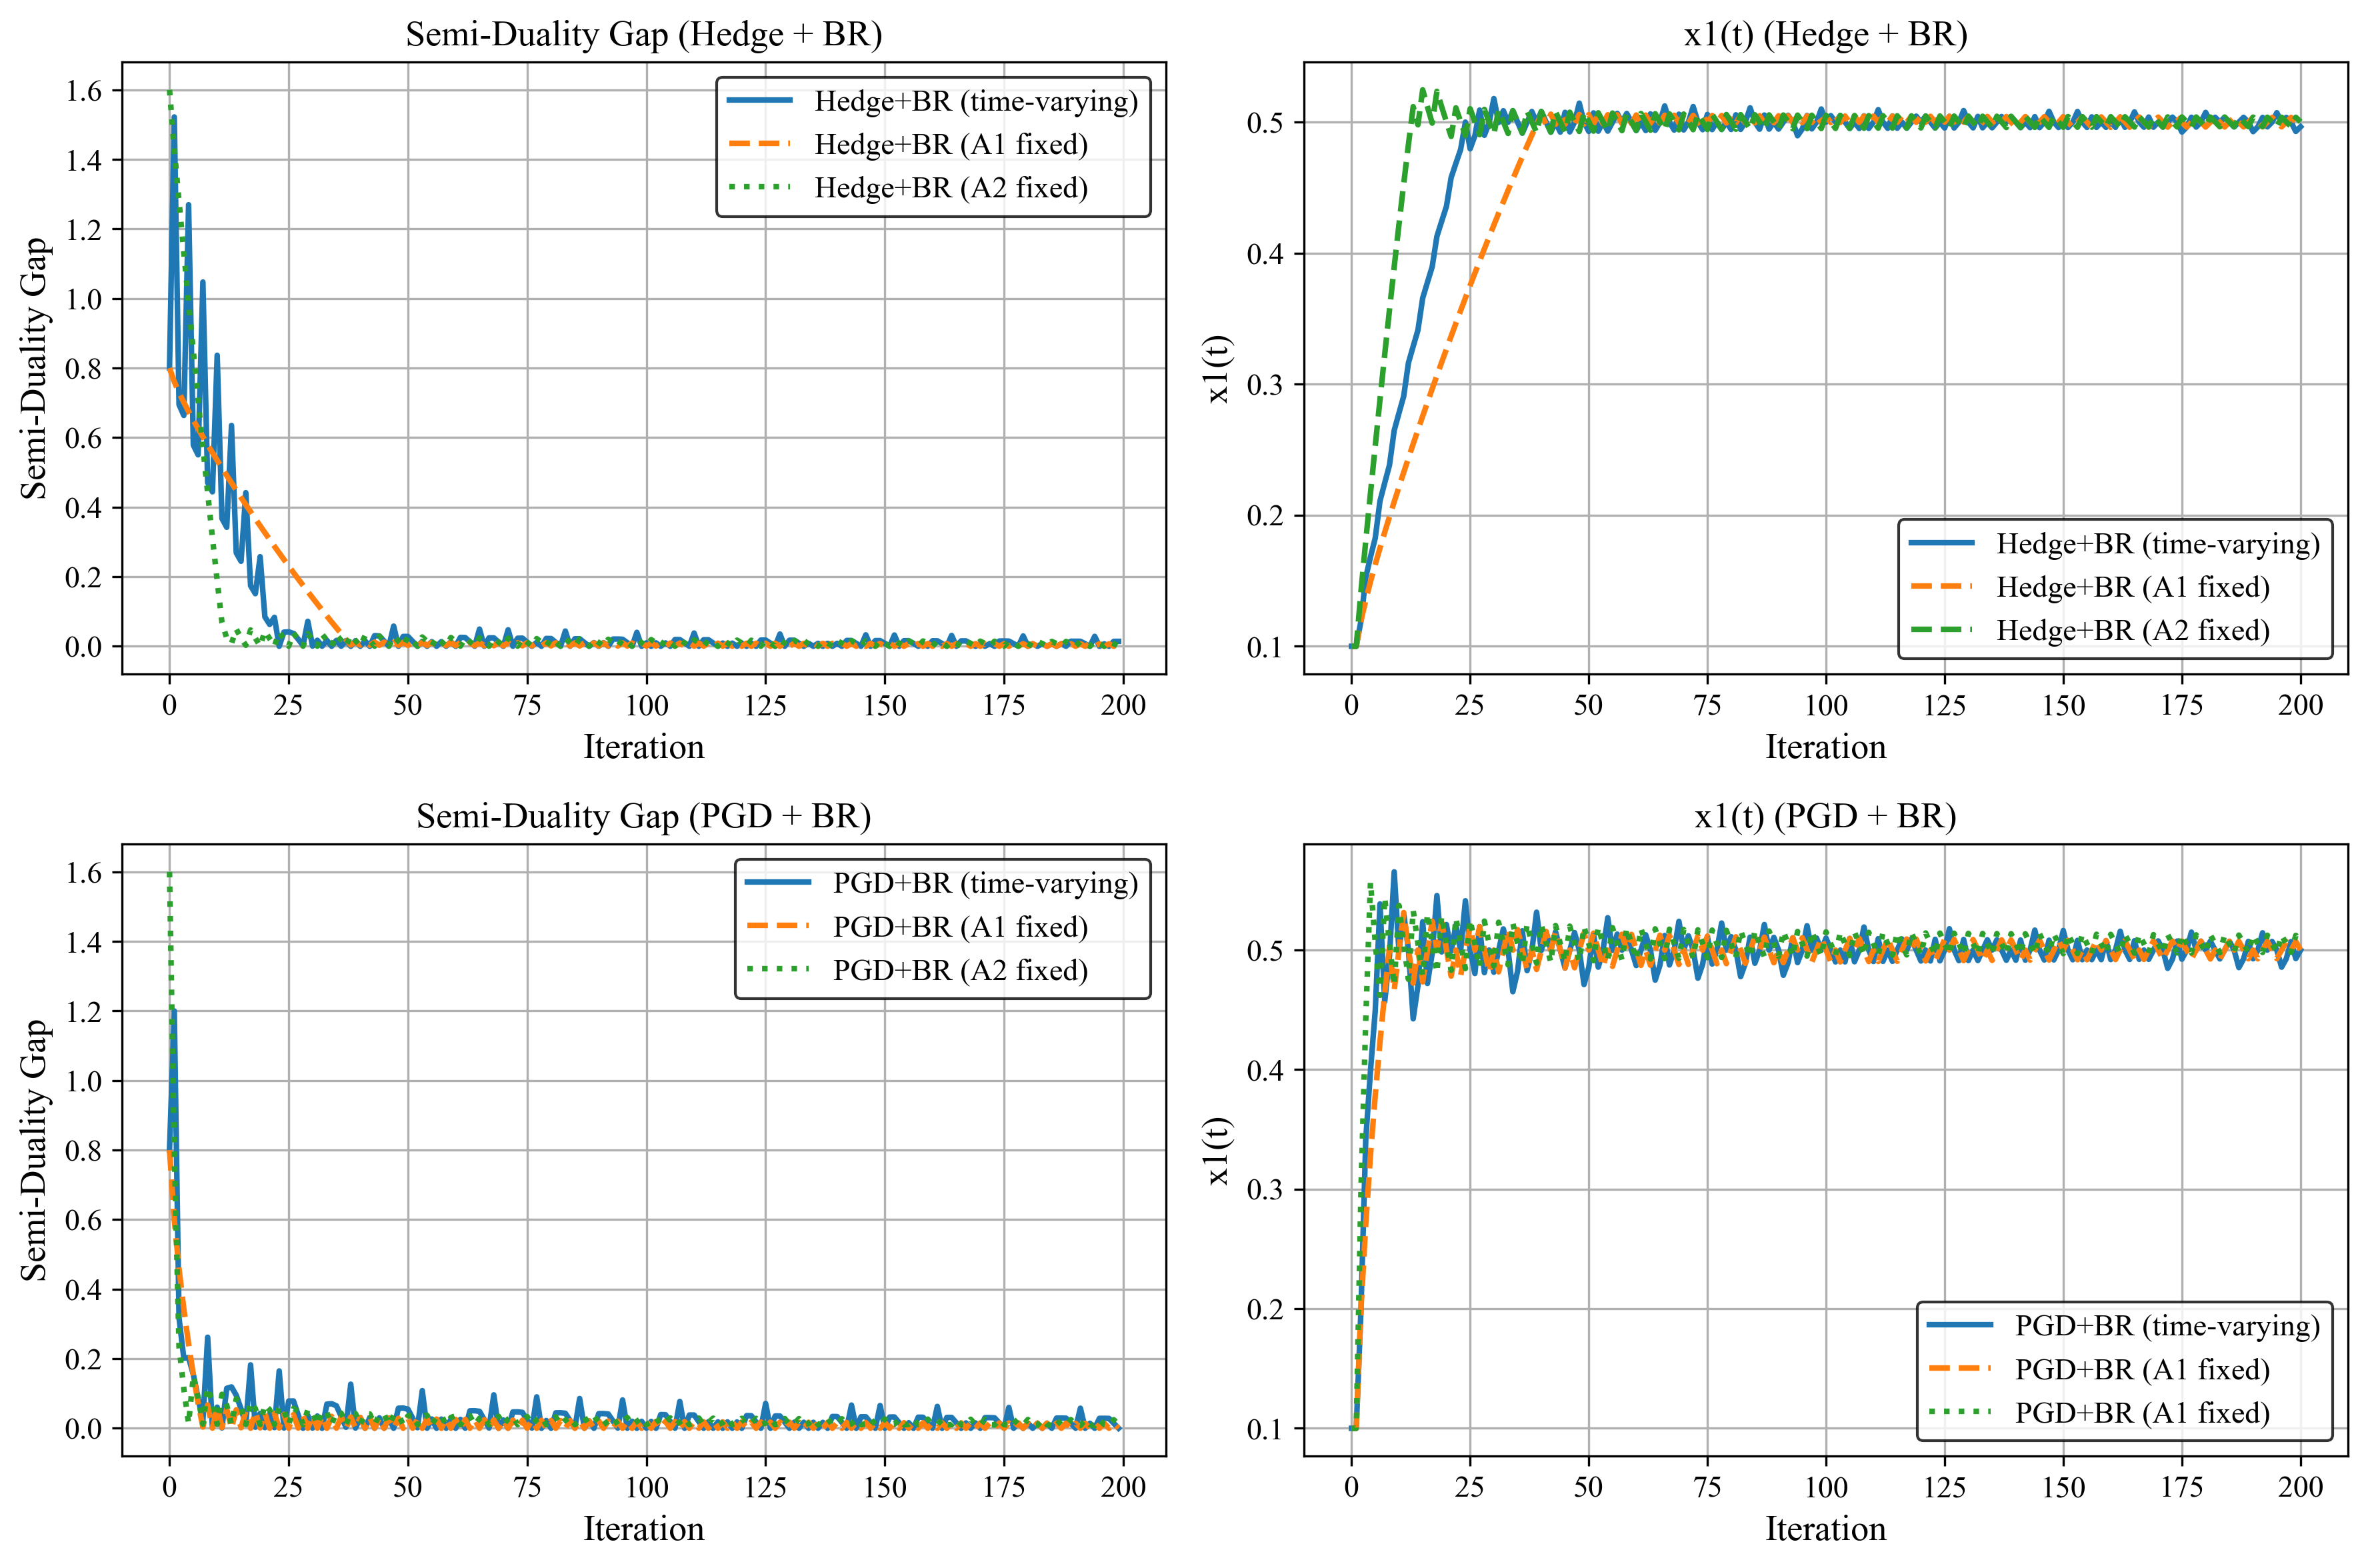

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# game matrix
A1 = np.array([[-1, 1], [1, -1]])
A2 = np.array([[2, -1], [0, 3]])
A3 = np.array([[0, 3], [2, -1]])
A_list = [A1, A2, A3]
v_list = [0, 1, 1]  # game value for each game
T = 200

lr_hbr = 0.1
lr_pbr = 0.1
rate = 0.5

# initial strategy
x0 = np.array([0.1, 0.9])

# time-varying games
A_seq = [A_list[t % 3] for t in range(T)]
v_seq = [v_list[t % 3] for t in range(T)]

x_hedge_tv, gap_hedge_tv = hedge_br(x0, A_list, v_list, T, rate, lr_hbr)
x_pgd_tv, gap_pgd_tv = pgd_br(x0, A_list, v_list, T, rate, lr_pbr)

# fixed games
x_hedge_fixed_1, gap_hedge_fixed_1 = hedge_br(x0, [A1]*T, [0]*T, T, rate, lr_hbr)
x_pgd_fixed_1, gap_pgd_fixed_1 = pgd_br(x0, [A1]*T, [0]*T, T, rate, lr_pbr)

x_hedge_fixed_2, gap_hedge_fixed_2 = hedge_br(x0, [A2]*T, [1]*T, T, rate, lr_hbr)
x_pgd_fixed_2, gap_pgd_fixed_2 = pgd_br(x0, [A2]*T, [1]*T, T, rate, lr_pbr)

# figures
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "legend.frameon": True,
    "legend.edgecolor": 'black',
    "figure.dpi": 300
})
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(gap_hedge_tv, label="Hedge+BR (time-varying)")
axes[0, 0].plot(gap_hedge_fixed_1, label="Hedge+BR (A1 fixed)", linestyle='--')
axes[0, 0].plot(gap_hedge_fixed_2, label="Hedge+BR (A2 fixed)", linestyle=':')
axes[0, 0].set_title("Semi-Duality Gap (Hedge + BR)")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Semi-Duality Gap")
axes[0, 0].legend()
axes[0, 0].grid(True)


axes[0, 1].plot(x_hedge_tv[:, 0], label="Hedge+BR (time-varying)")
axes[0, 1].plot(x_hedge_fixed_1[:, 0], label="Hedge+BR (A1 fixed)", linestyle='--')
axes[0, 1].plot(x_hedge_fixed_2[:, 0], label="Hedge+BR (A2 fixed)", linestyle='--')
axes[0, 1].set_title("x1(t) (Hedge + BR)")
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("x1(t)")
axes[0, 1].legend()
axes[0, 1].grid(True)


axes[1, 0].plot(gap_pgd_tv, label="PGD+BR (time-varying)")
axes[1, 0].plot(gap_pgd_fixed_1, label="PGD+BR (A1 fixed)", linestyle='--')
axes[1, 0].plot(gap_pgd_fixed_2, label="PGD+BR (A2 fixed)", linestyle=':')
axes[1, 0].set_title("Semi-Duality Gap (PGD + BR)")
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_ylabel("Semi-Duality Gap")
axes[1, 0].legend()
axes[1, 0].grid(True)


axes[1, 1].plot(x_pgd_tv[:, 0], label="PGD+BR (time-varying)")
axes[1, 1].plot(x_pgd_fixed_1[:, 0], label="PGD+BR (A1 fixed)", linestyle='--')
axes[1, 1].plot(x_pgd_fixed_2[:, 0], label="PGD+BR (A1 fixed)", linestyle=':')
axes[1, 1].set_title("x1(t) (PGD + BR)")
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_ylabel("x1(t)")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig("periodic_behavior.pdf", bbox_inches="tight")
plt.show()
